# Signal Segmentation
---
The audio data containing vocalisations are sourced from hydrophone recordings. Therefore, the wav files are typically upwards of an hour and consist of thousands of clicks. To extract each individual Bigeye click from these large files, the use of audio segmentation algorithms are explored subsequently. The effectiveness of these algorithms are measured by their ability to place boundaries at the start and end of vocalisation signals. 


## Imports:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from scipy import signal

## Control Parameters:

In [3]:
sr = 16000 #sample rate

## Helper functions:

In [114]:
'''
Description:
    Plots the boundaries along with signal waveform. 
Parameters:
    waveform (numpy.ndarray): array of signal amplitudes
    boundaries (numpy.ndarray): array of waveform indices where boundaries exist
    sr (int): sample rate of waveform
Return:
    None
'''
def plot_boundaries_on_signal(signal, boundaries, sr):
    hi, lo = max(signal), min(signal) 
    no_samples = len(signal)
    plt.vlines(boundaries/sr, lo, hi, colors='Red', linestyles='dotted')
    plt.hlines(0,0,no_samples/sr,colors='Grey', linestyles='dotted')
    plt.plot(np.linspace(0, no_samples/sr, no_samples), signal)

In [5]:
'''
Description:
    Slices a signal to [t1, t2), and optionally adjusts the boundary indices to the sliced signal.
Parameters:
    signal (numpy.ndarray): signal to slice
    t1 (int/float): lower bound in seconds
    t2 (int/float): upper bound in seconds
    boundaries (numpy.array): list of boundaries
Return:
    s_signal (numpy.array): sliced signal
    s_boundaries (numpy.array): boundaries adjusted to sliced signal 
'''
def signal_slice(signal, t1, t2, sr=sr, boundaries=None):
    t1 = int(t1*sr)
    t2 = int(t2*sr)
    signal = signal[t1:t2]
    if (boundaries is not None):
        boundaries = boundaries[(boundaries >= t1) & (boundaries <= t2)] #obtain boundaries in range
        boundaries -= t1
    return signal, boundaries

## Segmentation Algorithms:

In [148]:
'''
Description:
    Computes the windowed version of the non-linear energy operator (w-NLEO), 
    for the entire signal array returns an array containing boundary positions.
Parameters:
    data (numpy.ndarray): signal array
    window_size (int): size of windows to perform NLEO operation.
    threshold (float): minimum threshold for considering boundaries.
    min_separation (float): minimum degree of separation (seconds) required to be considered separate segment
    boundary_offset (float): Offset (seconds) boundary placement for specific alignment
    segment_duration (float): duration (seconds) of segment from starting-point of boundary
Return:
    segs (numpy.ndarray): array of segment positions
'''
def nonlinear_energy_operator(data, window_size, threshold, 
                                min_separation=0.1, boundary_offset=-0.005, segment_duration=0.1):
                                
    assert window_size > 1
    N = window_size//2

    w_nleo = [] # psi_n 
    for n in range(3+N, len(data)-N):
        w_nleo.append(sum(data[n-1-N : n+N])*sum(data[n-2-N : n-1+N]) - sum(data[n-N : n+1+N])*sum(data[n-3-N : n-2+N]))
    w_nleo = [w_nleo[0]]*(3+N) + w_nleo + [w_nleo[len(w_nleo)-1]]*(N) # padding nleo values with first and last values
    assert len(w_nleo) == len(data)

    gnleos = []
    for n in range(N-1, len(data)-N):
        gnleo = sum(w_nleo[n-N+1 : n+1]) - sum(w_nleo[n+1 : n+N+1])
        gnleos.append(gnleo)

    boundaries, _ = signal.find_peaks(gnleos, height=threshold)

    segs = []
    # boundaries are typically placed after spike. Offset of -5ms (default) to place boundary just before spike.
    boundaries = boundaries + int(boundary_offset * sr)
    boundaries = boundaries[boundaries > 0] # omit segments where offset causes start-points before 00m:00s 
    for i in range(1, len(boundaries)):
        # a boundary is only considered the start of a segment if it appears min_separation seconds after the previous boundary
        # else, it is considered part of same segment
        if (boundaries[i] - boundaries[i-1] > sr*min_separation): 
            segs.append(boundaries[i])
        else:
            boundaries[i] = boundaries[i-1]

    segs = np.asarray(segs)
    segs = np.sort(np.concatenate([segs, segs + int(segment_duration * sr)], axis=0),axis=0)
    return segs

In [7]:
'''
Description:
    Implementation of voice activity detection based on Energy and Zero-Crossing Rate, inspired by:
    https://github.com/rimshasaeed/Voice-Activity-Detection
    Note: verdict: 0 for silence, 1 for unvoiced, 2 for voiced.
        Here both voice and unvoiced are considered bigeye vocalisations to cleaned signal
Parameters:
    signal (numpy.ndarray): signal array
    window_size (float): size of windows (seconds) to perform NLEO operation.
    overlap (float): size of overlap (seconds) when sliding the window.
    min_separation (float): minimum degree of separation (seconds) required to be considered separate segment
    segment_duration (float): duration (seconds) of segment from starting-point of boundary
    sr (float): sample rate
    low_energy (float): Threshold for low short-time energy
    high_energy (float): Threshold for high short-time energy
    low_zcr (float): Threshold for low zero crossing rate
    high_zcr (float): Threshold for high zero crossing rate
Return:
    boundaries (numpy.ndarray): array of segment positions
'''
def energy_zcr_vad(signal, window_size, overlap, min_separation=0.1, segment_duration=0.1, sr=sr,
                    low_energy = 1.2, high_energy = 1.5, low_zcr = 0.0035, high_zcr = 0.0055):
                    
    assert window_size > overlap
    window_size = int(window_size * sr)
    overlap = int(overlap * sr)
    num_frames = len(signal)-overlap

    boundaries = []

    for i in range(0, num_frames, window_size-overlap):
        window = signal[i:i + window_size]
        if (len(window) != window_size):
            window = np.concatenate([window, np.asarray((window_size - len(window))*[0])])

        energy = sum(window**2)
        zcr = sum(abs(np.diff(window>0)*1))/len(window)
        verdict = 0

        if (energy < low_energy):
            if (zcr < low_zcr):
                verdict = 0
            elif zcr < high_zcr:
                verdict = 0
        elif (energy < high_energy):
            if (zcr < low_zcr):
                verdict = 1
            elif (zcr < high_zcr):
                verdict = 2
            else:
                verdict = 1
        else:
            verdict = 2
        
        if (verdict > 0):
            if (len(boundaries) == 0):
                boundaries.append(i)
            elif (i > 0 and i > boundaries[-1] + int(sr*min_separation)):
                boundaries.append(i)

    boundaries = np.array(boundaries)
    boundaries = np.sort(np.concatenate([boundaries, boundaries + int(segment_duration * sr)], axis=0),axis=0)          
    return boundaries

## Segmentation Analysis:

In [8]:
# loads an audio file as an numpp array containing signal amplitudes
sample, _ = librosa.load("data/samples/processed_67375127.140411201837_002510_002518.wav", sr=sr)

### Non-Linear Energy Operator:

In [152]:
# parameters set through experimentation. 
# window_size = 10, Threshold = 0.01 yields best compromise between efficiency and captured boundaries
boundaries_nleo = nonlinear_energy_operator(sample, 10, 0.000001)
print("Number of boundaries: ", len(boundaries_nleo))
print("Boundary locations: ", boundaries_nleo)

Number of boundaries:  30
Boundary locations:  [  3307   4907   9386  10986  14323  15923  16262  17862  19307  20907
  21408  23008  23500  25100  28455  30055  34183  35783  47214  48814
  77081  78681  83475  85075  90005  91605 103447 105047 119828 121428]


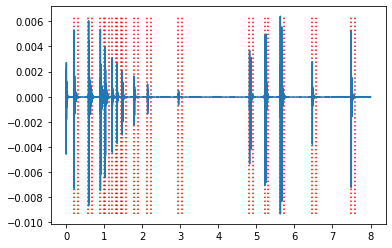

In [151]:
subsig_nleo, subbounds_nleo = signal_slice(sample, 0, 8, sr, boundaries_nleo)
plot_boundaries_on_signal(subsig_nleo, subbounds_nleo, sr)

### Short-Time Energy Zero Crossing:

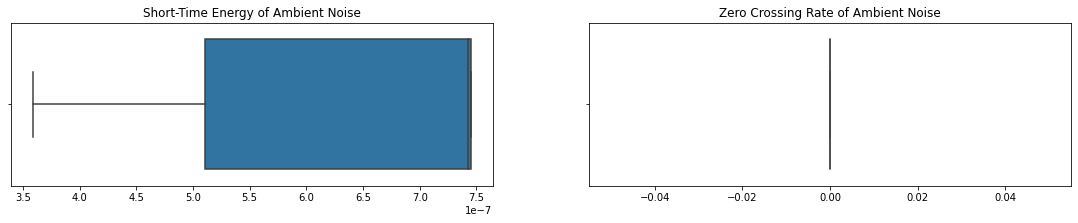

In [25]:
noise_sample, _ = signal_slice(sample, 3.1, 4.8, sr)
noise_energy = []
noise_zcr = []
for i in np.arange(0, 1.7, 0.05):
    frac = noise_sample[int(i*sr) : int((i+0.05)*sr)]
    noise_energy.append(sum(frac**2))
    noise_zcr.append(sum(abs(np.diff(frac>0)*1))/len(frac))

plt.figure(figsize=(19, 3))
plt.subplot(1,2,1)
sns.boxplot(x=noise_energy)
plt.title('Short-Time Energy of Ambient Noise')
plt.subplot(1,2,2)
sns.boxplot(x=noise_zcr, color='Crimson')
plt.title('Zero Crossing Rate of Ambient Noise')
plt.show()

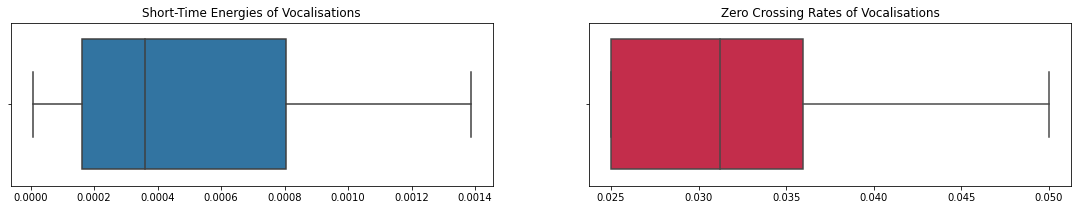

In [27]:
click_energy = []
click_zcr = []
# using every second boundary to get starting points of clicks.
# nleo_boundaries being used for analysis since already established
for i in range(0,len(boundaries_nleo)-1,2):
    frac = sample[boundaries_nleo[i] : boundaries_nleo[i] + int(sr*0.01)]
    click_energy.append(sum(frac**2))
    click_zcr.append(sum(abs(np.diff(frac>0)*1))/len(frac))

plt.figure(figsize=(19, 3))
plt.subplot(1,2,1)
sns.boxplot(x=click_energy)
plt.title('Short-Time Energies of Vocalisations')
plt.subplot(1,2,2)
sns.boxplot(x=click_zcr, color='Crimson')
plt.title('Zero Crossing Rates of Vocalisations')
plt.show()

In [37]:
# boundaries_ezcr = energy_zcr_vad(sample, 0.01, 0.001, low_energy=0.16, high_energy=0.5, low_zcr=0.015, high_zcr=0.03) # sr = 8000
# boundaries_ezcr = energy_zcr_vad(sample, 0.01, 0.005, low_energy=1.0, high_energy=1.2, low_zcr=0.003, high_zcr=0.0055) # sr = 48000
boundaries_ezcr = energy_zcr_vad(sample, 0.01, 0.001, low_energy=0.000001, high_energy=0.0002, low_zcr=0.005, high_zcr=0.025) # sr = 16000
print("Number of boundaries: ", len(boundaries_ezcr))
print("Boundary locations: ", boundaries_ezcr)

Number of boundaries:  34
Boundary locations:  [     0   1600   3312   4912   9360  10960  11088  12688  14256  15856
  15984  17584  19296  20896  21312  22912  23472  25072  28368  29968
  34128  35728  47232  48832  77040  78640  83376  84976  90000  91600
 103392 104992 119808 121408]


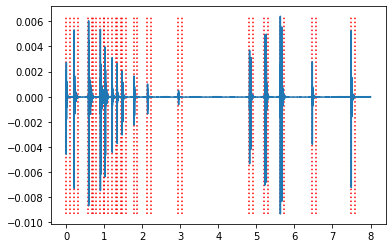

In [150]:
subsig_ezcr, subbounds_ezcr = signal_slice(sample, 0, 8, sr, boundaries_ezcr)
plot_boundaries_on_signal(subsig_ezcr, subbounds_ezcr, sr)